# Calculate CESM Indeces

This file :
- calculates all the indeces for all months for all cesmFullForcingFiles 
- applies a time average to give a warm-season average for each index
- finds when events are compounding to be fire pos or fire neg in south-east Australia

Indices are defined in utilts/_index.py
Experiment set is defined in utils/_model.py



In [1]:
#import my functions
import helpers.fileHandler as fh
import utils._modelDefinitions as _model
import utils.sstIndex as sst
import utils.pslIndex as psl
import utils.timePeriod as tp
import utils.compound as compound


In [2]:
import xarray
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings('ignore')

# 1. Calculate CESM Indeces

Data for climatology

In [ ]:
sstClimatDs=fh.loadModelData('CESM-LME', 'SST', '0850cntl.001')
pslClimatDs=fh.loadModelData('CESM-LME', 'PSL', '0850cntl.001')

sstClimat=sst.calculateClimatology(sstClimatDs, 850, 2005)
pslClimat=psl.calculateClimatology(pslClimatDs, 850, 2005)

#loading both those things
for keys in sstClimat:
    sstClimat[keys].load()
    
pslClimat.load()

In [ ]:
sstClimatDs.close()
pslClimatDs.close()

For each experiment in Full Forcings, calculate all the indeces

In [ ]:
timePIndeces=dict()

for experiment in _model.cesmAll:
    print(experiment)
    sstDs = fh.loadModelData('CESM-LME', 'SST', experiment)
    pslDs = fh.loadModelData('CESM-LME', 'PSL', experiment)
    pslIndex, junk = psl.calculateSamIndex(pslDs, pslClimat)
    sstIndex = sst.calculateIndex(sstDs, sstClimat) #(reducing the model set at this step could save time?)
    indeces = xarray.merge([pslIndex, sstIndex])
    indeces.assign_attrs(climatology='calculated based on 850-2005 climatology from the control run')
    indeces.to_netcdf('results/cesmMonthlyIndeces/' + experiment + '.nc')

    

# RCP8.5 extensions are a special case

    if experiment in ['002','003', '008', '009']:

        #pre2005Ds = xarray.load_dataset('results/cesmMonthlyIndeces/' + experiment + '.nc')

        print('LME.'+experiment)

        sstDs = fh.loadModelData('CESM-LME', 'SST', 'LME\.'+experiment)

        extensionSstIndex=sst.calculateIndex(sstDs, sstClimat)

        sstIndex = xarray.concat(
            [sstIndex,
             extensionSstIndex],
            'time'
        )


        pslDs = fh.loadModelData('CESM-LME', 'PSL', 'LME.'+experiment)

        extensionPslIndex, junk =psl.calculateSamIndex(pslDs, pslClimat)

        pslIndex=xarray.concat(
            [pslIndex,
             extensionPslIndex],
            'time'
        )

        indeces = xarray.merge([pslIndex, sstIndex])
        indeces.assign_attrs(climatology='calculated based on 850-1850 climatology')
        indeces.to_netcdf('results/cesmMonthlyIndeces/LME.' + experiment + '.nc')

    


In [ ]:
#loading both those things
for keys in sstClimat:
    sstClimat[keys].close()
    
pslClimat.close()

# 2. Average over the time period of interest to give an annual index

This grabs the monthly CESM indeces, and calculates the averages for the time periods of interest (aka the warm season), as set in the _indexDefitionions file

Theres a few examples of output at the bottom to sanity check this is meaningful

The indeces for each month have already been calculated. So loading up the saved versions, and putting them into a single xarray.

In [ ]:
timePIndeces=list()

for experiment in _model.cesmAll:
    print(experiment)
    indecesDs = xarray.open_dataset('results/cesmMonthlyIndeces/' + experiment + '.nc')

    timePIndeces.append(tp.averageForTimePeriod(indecesDs))


results=xarray.concat(timePIndeces, 'experiment')


results['experiment']=experimentSet

results=results.assign_attrs({**indecesDs.attrs,**_index.monthsOfInterest})

Save the result for use later

In [ ]:
results.to_netcdf('results/cesmTradIndeces.nc')

# 2.a Some sanity checks to see if it looks ok:


In [ ]:
results

In [ ]:
# plotSomething
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

#results.sel(experiment='001', index='nino34').plot(label='001')
results.nino34.sel(experiment='LME.002').plot(label='LME.001')
results.nino34NoDetrend.sel(experiment='LME.002').plot(label='LME.001')

#Tidy up a bit
plt.title("CESM Full Forcing Nino34 Ensemble")
plt.ylim(-4,4)
plt.minorticks_on()
plt.legend()

In [ ]:
# A multi-experiment mean?

mean = results.sam.mean(dim='experiment')
std = results.sam.std(dim='experiment')

In [ ]:
plt.figure()
mean.plot()
std.plot()

In [ ]:
# why limit yourself to one index?

mean = results.mean(dim='experiment')
std = results.std(dim='experiment')

In [ ]:
std

# 3. Calculate Compound Years for CESM

In [4]:
# Here is the data
indecesDs = xarray.open_dataset('results/cesmTradIndeces.nc')

indecesDs.experiment.values

array(['LME.002', 'LME.003', 'LME.008', 'LME.009', '0850cntl.001', '001',
       '002', '003', '004', '005', '006', '007', '008', '009', '010',
       '011', '012', '013'], dtype=object)

So we are going to define events as follows:
- For SST indeces (aka Enso and Iod), this is 1 sigma above/below mean
- For PSL indeces (aka Sam) this is 0.5 sigma above/below mean

Using the control run as climatology

In [5]:
# This should calculate stds for all experiments and all indeces
stdDa = indecesDs.sel(experiment=_model.cesmCntl).std(dim='year')

In [6]:
# define some criteria that we want to use to identifiy it thats an event. Its the same for evey experiment this time
criteriaDa= xarray.merge(
    (stdDa[['nino34','dmi']], stdDa['sam']/2)
)

# criteria is the same for every experiment becuase it comes from the climatology
criteriaDa = xarray.concat([
    criteriaDa for i in range(0,len(_model.cesmAll))
], 'experiment')
criteriaDa['experiment'] = _model.cesmAll

criteriaDa

<xarray.Dataset>
Dimensions:     (experiment: 18)
Coordinates:
  * experiment  (experiment) <U12 'LME.002' 'LME.003' 'LME.008' ... '012' '013'
Data variables:
    nino34      (experiment) float64 1.05 1.05 1.05 1.05 ... 1.05 1.05 1.05 1.05
    dmi         (experiment) float64 1.309 1.309 1.309 ... 1.309 1.309 1.309
    sam         (experiment) float64 0.6559 0.6559 0.6559 ... 0.6559 0.6559

<b>Calculate the compounding years and plot an example</b>

In [9]:



firePos, fireNeg = compound.applyCriteria(indecesDs, criteriaDa)

firePos=compound.compound(firePos)

fireNeg=compound.compound(fireNeg)

firePos.to_netcdf('results/cesmFirePos.nc')

fireNeg.to_netcdf('results/cesmFireNeg.nc')

In [13]:
#check that years where this is no-data is a nan (rather than 0)
firePos.sel(experiment='001')

<xarray.Dataset>
Dimensions:      (year: 1250)
Coordinates:
  * year         (year) int64 850 851 852 853 854 ... 2095 2096 2097 2098 2099
    experiment   <U3 '001'
Data variables:
    dmi          (year) float64 0.0 0.0 1.0 0.0 1.0 0.0 ... nan nan nan nan nan
    nino34       (year) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    sam          (year) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    nEvents      (year) float64 2.0 2.0 1.0 2.0 1.0 0.0 ... nan nan nan nan nan
    all3         (year) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    nino34+dmi   (year) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    nino34+sam   (year) float64 1.0 0.0 0.0 1.0 0.0 0.0 ... nan nan nan nan nan
    dmi+sam      (year) float64 0.0 1.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    anyCompound  (year) float64 1.0 1.0 0.0 1.0 0.0 0.0 ... nan nan nan nan nan
Attributes:
    all3:     ['nino34', 'dmi', 'sam']
    indeces:  ['nino34', 'dmi', 'sam']
    pairs:    ['nino34+dmi', 'nino34+sam', 'dmi+sam']

Text(0.5, 1.0, 'LME.002: Pairs and all-three compounds for individal years')

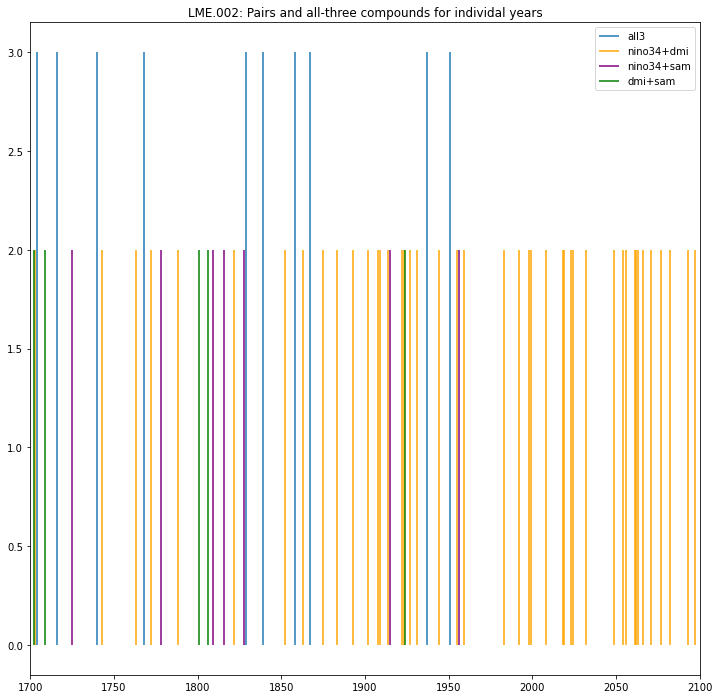

In [11]:
#plot an example
expToPlot = 'LME.002'

toPlot=3*firePos.all3.sel(experiment=expToPlot)

plt.figure(figsize=(12,12))

plt.vlines(
    x=firePos.year, 
    ymin=0,
    ymax=toPlot,
    label='all3'
)

colors=['orange', 'purple', 'green']
iCol = 0

for iPair in firePos.attrs['pairs']:
    plt.vlines(
        x=firePos.year, 
        ymin=0,
        ymax=2*firePos[iPair].sel(experiment=expToPlot),
        color=colors[iCol],
        label=iPair
    )
    iCol+=1
plt.legend()
plt.xlim(1700,2100)
plt.title(expToPlot+': Pairs and all-three compounds for individal years')